# Gibbs sampler for normal distribution

Random Markov Fields together with quadratic sub-potentials lead to a high-dimensional normal distribution:

* Quadratic sub-potentials fix an inverse covariance matrix.
* Covariance matrix $\Sigma$ can be by inverting the inverse covariance matrix.
* Multivariate normal distributions can sampled with `scipy`.

However, this quickly becomes infeasible if image sizes go beyond $32\times 32$. Thus we need a method for sampling images without the inversion.
This can be done with a [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) algorithm that iteratively updates individual pixels $x_{ij}$ until sufficiently many iterations are carried out and we have an image that comes from a distribution that is very close to our target distribution.

In [60]:
import numpy as np
import pandas as pd

from pandas import DataFrame
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Standard Gibbs sampling algorithm for normal distribution


To sample a two-dimensional normal distribution with parameters $\boldsymbol{\mu}$ and $\Sigma$ we need to do following steps:

* Initialise values of $x, y$ with some value. The mean $(\mu_1,\mu_2)$ is good starting point. 

* Sample a new value of $x$ from a conditional probability distribution $p(x|y,\Sigma,\boldsymbol{\mu})$

* Sample a new value of $y$ from a conditional probability distribution $p(y|x,\Sigma,\boldsymbol{\mu})$

* Repeat these two last steps until convergence.


**Known issues:** 
* It can be quite tricky to determine whether the number of iterations is sufficient or not. 
* The number of iterations can be quite large – sometimes around one million. You can try with 1000 iterations.

**Known shoercuts:**
* Conditional distributions are univariate normal distributions.
* Its parameters can be looked up from The Matrix Cookbook. 
* Parameters for $p(x|y,\Sigma,\boldsymbol{\mu})$:

\begin{align*}
\begin{cases}
\mu_x=\mu_x+ \Sigma_{x,y}\Sigma_{y,y}^{-1}(y-\mu_y)\\
\sigma_x=\Sigma_{x,x} - \Sigma_{x,y}\Sigma_{y,y}^{-1}\Sigma_{x,y}
\end{cases}\\
\end{align*}

* Parameters for $p(y|x,\Sigma,\boldsymbol{\mu})$:

\begin{align*}
\begin{cases}
\mu_x=\mu_x+ \Sigma_{x,y}\Sigma_{y,y}^{-1}(y-\mu_y)\\
\sigma_x=\Sigma_{x,x} - \Sigma_{x,y}\Sigma_{y,y}^{-1}\Sigma_{x,y}
\end{cases}\\
\end{align*}

### Implementation
The code is taken from  [Agustinus Kristiadi's Blog](https://wiseodd.github.io/techblog/2015/10/09/gibbs-sampling/).

In [58]:
def p_x_given_y(y, mus, sigmas):
    mu = mus[0] + sigmas[1, 0] / sigmas[1, 1] * (y - mus[1])
    sigma = sigmas[0, 0] - sigmas[1, 0] / sigmas[1, 1] * sigmas[1, 0]
    return np.random.normal(mu, sigma)


def p_y_given_x(x, mus, sigmas):
    mu = mus[1] + sigmas[0, 1] / sigmas[0, 0] * (x - mus[0])
    sigma = sigmas[1, 1] - sigmas[0, 1] / sigmas[0, 0] * sigmas[0, 1]
    return np.random.normal(mu, sigma)


def gibbs_sampling(mus, sigmas, iter=10000):
    samples = np.zeros((iter, 2))
    y = np.random.rand() * 10

    for i in range(iter):
        x = p_x_given_y(y, mus, sigmas)
        y = p_y_given_x(x, mus, sigmas)
        samples[i, :] = [x, y]

    return DataFrame(samples).rename(columns={0: 'x', 1: 'y'})

### Run and visualisation


,x,y
0,3.748687,3.757428
1,3.657790,3.417638
2,3.257421,3.051261
3,3.384291,3.251540
4,3.289823,3.601342


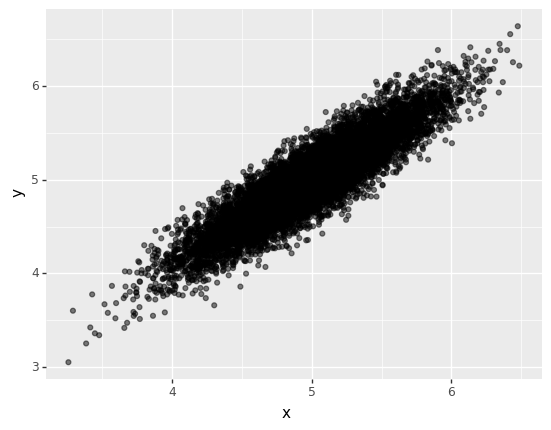

<ggplot: (-9223372036515020789)>

In [66]:
mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])
df = gibbs_sampling(mus, sigmas)
display(head(df))
display(ggplot(df) + geom_point(aes(x = 'x', y = 'y'), alpha = 0.5))

## II. Gibbs sampling algorithm for Random Markov Fields


The Gibbs sampling algorithm adjusted to sampling images based on Random Markov Fields is the following:

* Initialize starting values of $x_{i,j}$ for $i \in \{1,\ldots, m\}$ and $j\in\{1,\ldots,n\}$.
* Order the $m × n$ grid of pixels and for each variable $x_{i,j}$ in the specified order do:
   * Sample $x_{i,j}$ based on its neigbours, i.e., $p[x_{i,j}|\mathcal{N}(x_{i,j})]$.
* Repeat the last step until convergence.     


Note that if we fix  $x_{ij}$ for known pixels, the algorithm also provides a reconstructed image.

### Conditional probabilities

It is possible to specify the distribution through sub-potentials but then it is non-trivial to find the formula for the conditional probability.

<img src = 'illustrations/markov-random-field-ii.png' width=100%>

As a way out, we specify the conditional distribution through sub-potentials

\begin{align*}
p[x_4| x_1, x_3,x_5,x_7]
&\propto \exp\Bigl( -\frac{\alpha}{2}(x_1-x_4)^2  -\frac{\alpha}{2}(x_7-x_4)^2-  \frac{\beta}{2}(x_3-x_4)^2-\frac{\beta}{2}(x_5-x_4)^2-\frac{\delta^2}{2} x_4^2\Bigr)\\
&\propto \exp\Bigl( -(\alpha+\beta+\delta/2)x_4^2 + x_4(\alpha x_1+\alpha x_7+\beta x_3+\beta x_5)\Bigr)\\
&\propto \exp\Bigl(-(\alpha+\beta+\delta^2/2)(x_4^2 + 2\cdot\frac{\alpha (x_1+x_7)+\beta (x_3+x_5)}{2\alpha+2\beta+\delta^2}\cdot x_4\Bigr)\\
&\propto \exp\Biggl(-(\alpha+\beta+\delta^2/2)\Bigl(x_4 - 2\frac{\alpha (x_1+x_7)+\beta (x_3+x_5)}{2\alpha+2\beta+\delta^2}\Bigr)^2\Biggr)\\
\end{align*}

and thus the conditional distrinution for $x_4$ is a normal distribution with parameters

\begin{align*}
\mu&=\frac{\alpha (x_1+x_7)+\beta (x_3+x_5)}{2\alpha+2\beta+\delta}\\
\sigma^2&=2\alpha+2\beta+\delta^2
\end{align*}

### Sampling strategy

* Double-iteration over the image matrix is extremely slow.
* A single modification alters only the neighbours of its neighbours   
* Parrallel updates for $3\times 3$ patches are possible. 
* We can define 9 sub-matrices and updates each of them in parallel
* Moreover sampling parameters can be computed using linear combinations of these matrices. 
* As a result, we can use parallel operations in `numpy` and `scipy`.
* The package `tensorflow_probability` is even more appropriate.

# Homeworks

## 3.1 Gibbs sampler for 2 by 2 grid (<font color='red'>1p + 1p</font>)

Let us consider four element Markov field

<img src = 'illustrations/markov-random-field-iv.png' width=100%>

where all random variales $X_i$ have only two states $\{0,1\}$ and the node is set to $1$ with the following probability
 

|Left |Right |Probability 
|---|---|---|
| 0 | 0 | $1/4$ |
| 0 | 1 | $1/4$ |
| 1 | 0 | $1/4$ |
| 1 | 1 | $3/4$ | 

Write a corresponding gibbs sampler and run enough samples to estimate the probabilities of all 16 configurations. You should discard first 1000 samples and then use the standard frequency counting. Note that individual observations are dependent but the frequencies still converge to the true probabailities. You can skip samples if you want to get more independent samples (<font color='red'>1p</font>).

Use the method of subpotentials to defive the closed formula.
Note that we have only four maximal cliques and we need to define four function $\Psi_1,\ldots, \Psi_4$. Each of those functions takes two arguments and thus

\begin{align*}
\Pr[\boldsymbol{x}]
&\propto \exp\bigl(-\Psi_1(x_1, x_2)- \Psi_2(x_2, x_3)-\Psi_3(x_3, x_4)-\Psi_4(x_4, x_1)\bigr)\\
&\propto \psi_1(x_1, x_2)\cdot\psi_2(x_2, x_3)\cdot\psi_3(x_3, x_4)\cdot\psi_4(x_4, x_1)
\end{align*}

If you express the probabilities of all 16 configurations

|$X_1$ | $X_2$ | $X_3$ | $X_4$ |$\Pr$ 
|---|---|---|---|---|
| 0 | 1 | 0 | 0 | $\psi_1(0, 1)\cdot\psi_2(1, 0)\cdot\psi_3(0, 0)\cdot\psi_4(0, 0)$ | 
| 0 | 1 | 0 | 1 | $\psi_1(0, 1)\cdot\psi_2(1, 0)\cdot\psi_3(0, 1)\cdot\psi_4(1, 0)$ |  
| 0 | 0 | 0 | 0 | $\psi_1(0, 0)\cdot\psi_2(0, 0)\cdot\psi_3(0, 0)\cdot\psi_4(0, 0)$ | 
| 0 | 0 | 0 | 1 | $\psi_1(0, 0)\cdot\psi_2(0, 0)\cdot\psi_3(0, 1)\cdot\psi_4(1, 0)$ | 

from which you get constraints to the values of $\psi_i(\cdot,\cdot)$ and can find analytical solution (<font color='red'>1p</font>).


## 3.2 Large-scale modelling of textures (<font color='red'>3p</font>)

Define a Gibbs sampler for $128\times 128$ images and compare how different are sample images for four and eight pixel neighbourhoods  

<table width=80%>
    <tr>
        <td>
        <img src = 'illustrations/markov-random-field-ii.png' width=100%>
        </td>
        <td>
        <img src = 'illustrations/markov-random-field-iii.png' width=100%>
        </td>
    </tr>
</table>        

Experiment with different $\alpha, \beta, \gamma,\delta$ values. What happens if you take the output of four pixel neighbourhood Markov Random Field as an initial state for the Gibbs sampler with the eight pixel neighbourhood.



## 3.2 Large-scale non-gaussian modelling of textures (<font color='red'>3p + 2p</font>)

So far we have considered Random Markov Fields with where conditional distributions are
normal distributions with very restricted parameter set. 
We can still assume that the conditional distribution $x_i$ given its neighbours is normal distribution $\mathcal{N}(\mu,\sigma)$ where $\mu, \sigma$ can depend non-linearly on the intensities of the neighbouring pixels.  

For simplicity assume that $\sigma$ is constant. Then one can learn the conditional distribution by finding a predictor of $x_i$ that minimises mean square error.
Technically, one should use non-overlapping patches to learn the model but in practice you can look at all possible windows of a particular texture.

Perform the following estimation cycle:

* Pick large enough reighbourhood definition,
* Train your favorite non-linear model $f$ for predicting $x_i$.
* Use $f$ to predict $\mu_i$ values for all patches.
* Estmate $\sigma$ from residuals $x_i-\mu_i$.

Next use Gibbs sampler to generate random images. Try also impute missing values.
Estimate visually how well imputation works. For simplicity use only grayscale images.
